In [43]:
import pandas as pd
import json
import glob
import tqdm
import seaborn as sns
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")

from model_drift import settings



In [44]:
def converter(value):
    if isinstance(value, list):
        d = {str(i):vv for i, vv in enumerate(value)}
        d['all'] = value
        return d
    return value

In [45]:
df = []

jsonl_dir = str(settings.DATA_DIR.joinpath("red_head_h0x1hbjf"))
jsonl_files = glob.glob(f"{jsonl_dir}/*.jsonl")

for fn in tqdm.tqdm_notebook(jsonl_files):
    with open(fn, 'r') as f:
        for line in tqdm.tqdm_notebook(f.readlines()):
            df.append({k: converter(v) for k, v in json.loads(line).items()})
print(len(df))
df = pd.json_normalize(df)
print(len(df))
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/26387 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
pc_df = pd.read_csv(settings.PADCHEST_FILENAME, low_memory=False)

In [ ]:
pc_df_vae = pc_df.merge(df, left_on="ImageID", right_on="index", how='inner')

In [ ]:
## Include this?

pc_df_vae["Projection"].value_counts()
pc_df_vae["View"] = pc_df_vae["Projection"]
pc_df_vae.loc[pc_df_vae["View"].isin(["PA", "AP_horizontal", "AP"]), "View"] = 'Frontal'
pc_df_vae['View'].value_counts()

Frontal    72048
L          33115
COSTAL       367
UNK            1
Name: View, dtype: int64

In [ ]:
cols = [c for c in list(pc_df_vae) if c.startswith("mu.") and 'all' not in c]
cols

['mu.0',
 'mu.1',
 'mu.2',
 'mu.3',
 'mu.4',
 'mu.5',
 'mu.6',
 'mu.7',
 'mu.8',
 'mu.9',
 'mu.10',
 'mu.11',
 'mu.12',
 'mu.13',
 'mu.14',
 'mu.15',
 'mu.16',
 'mu.17',
 'mu.18',
 'mu.19',
 'mu.20',
 'mu.21',
 'mu.22',
 'mu.23',
 'mu.24',
 'mu.25',
 'mu.26',
 'mu.27',
 'mu.28',
 'mu.29',
 'mu.30',
 'mu.31',
 'mu.32',
 'mu.33',
 'mu.34',
 'mu.35',
 'mu.36',
 'mu.37',
 'mu.38',
 'mu.39',
 'mu.40',
 'mu.41',
 'mu.42',
 'mu.43',
 'mu.44',
 'mu.45',
 'mu.46',
 'mu.47',
 'mu.48',
 'mu.49',
 'mu.50',
 'mu.51',
 'mu.52',
 'mu.53',
 'mu.54',
 'mu.55',
 'mu.56',
 'mu.57',
 'mu.58',
 'mu.59',
 'mu.60',
 'mu.61',
 'mu.62',
 'mu.63',
 'mu.64',
 'mu.65',
 'mu.66',
 'mu.67',
 'mu.68',
 'mu.69',
 'mu.70',
 'mu.71',
 'mu.72',
 'mu.73',
 'mu.74',
 'mu.75',
 'mu.76',
 'mu.77',
 'mu.78',
 'mu.79',
 'mu.80',
 'mu.81',
 'mu.82',
 'mu.83',
 'mu.84',
 'mu.85',
 'mu.86',
 'mu.87',
 'mu.88',
 'mu.89',
 'mu.90',
 'mu.91',
 'mu.92',
 'mu.93',
 'mu.94',
 'mu.95',
 'mu.96',
 'mu.97',
 'mu.98',
 'mu.99',
 'mu.100',

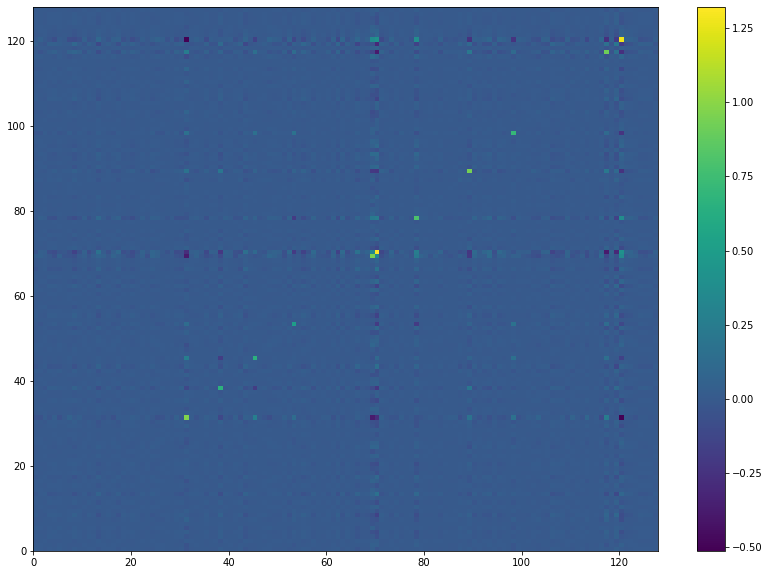

In [ ]:
cov = pc_df_vae[cols].cov().values
fig, ax = plt.subplots(1,1, figsize=(14,10))
pcm = ax.pcolormesh(cov)
fig.colorbar(pcm, ax=ax)

In [68]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

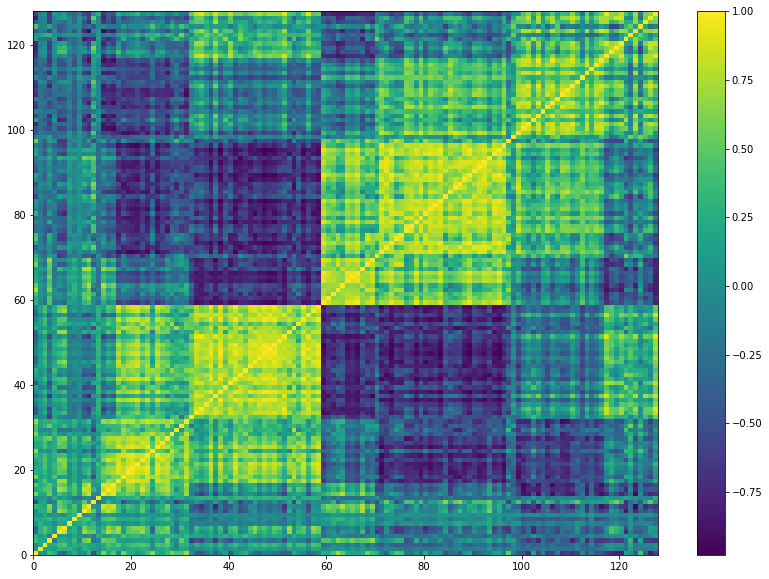

In [73]:
corr = pc_df_vae[cols].corr()
corr = cluster_corr(corr)

fig, ax = plt.subplots(1,1, figsize=(14,10))
pcm = ax.pcolormesh(corr)
fig.colorbar(pcm, ax=ax)

In [40]:
ixes = np.where(~np.eye(cov.shape[0],dtype=bool))

np.abs(cov[ixes]).max(), np.abs(cov[ixes]).min()

(0.5112345625920593, 5.72507158759149e-07)

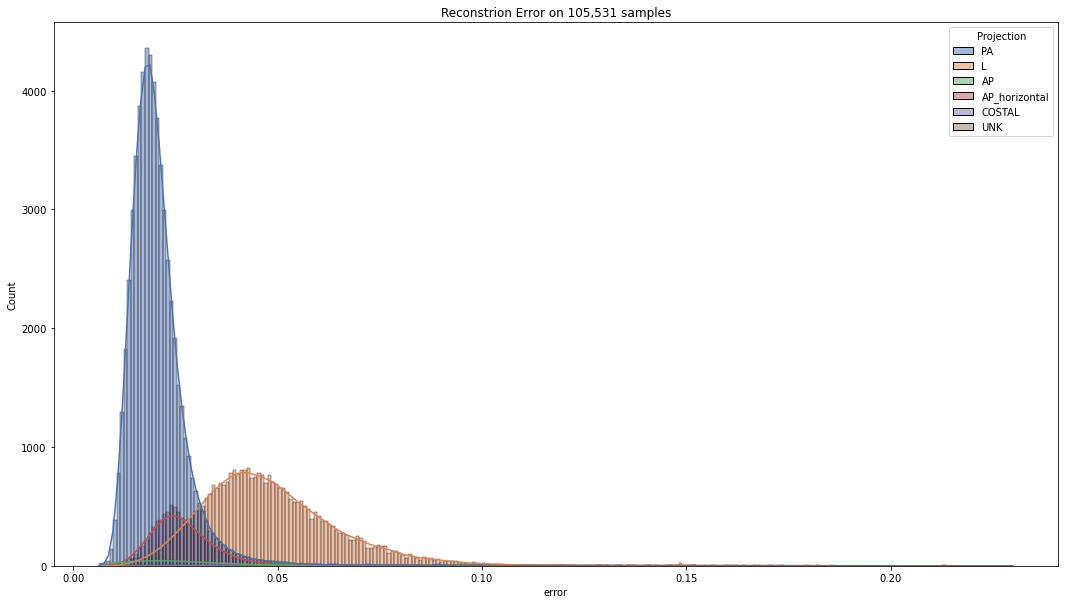

In [74]:
sns.set_palette('deep')
figsize = [18, 10]
fig, ax = plt.subplots(figsize=figsize)
hue = "Projection"

_ = sns.histplot(data=pc_df_vae, x="error", hue=hue, ax=ax, kde=True)
_ = ax.set(title=f"Reconstrion Error on {len(pc_df_vae):,d} samples")

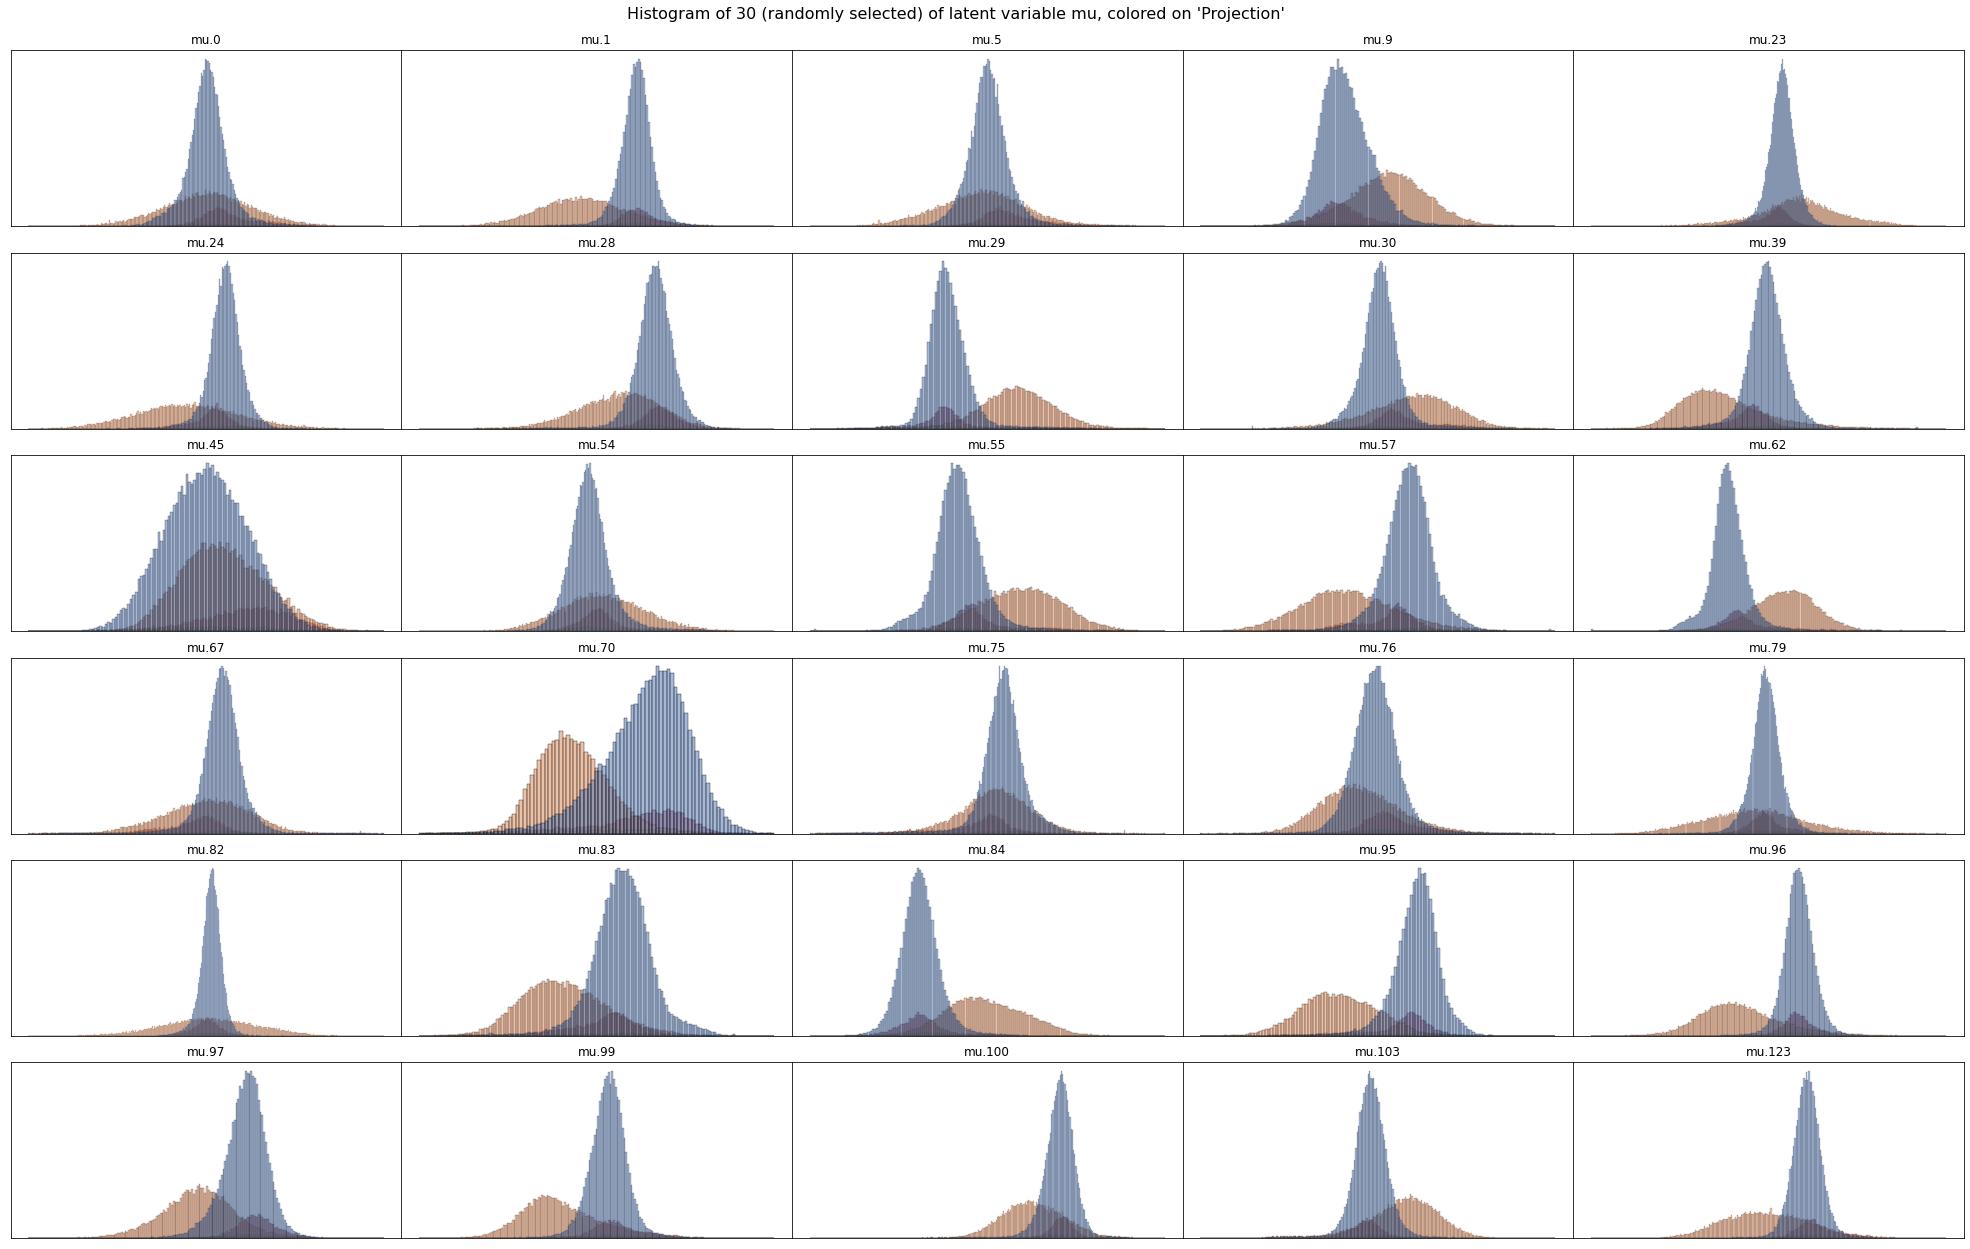

In [16]:
import random
grid_size = (6, 5)
figsize = [35, 20]
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize, gridspec_kw={'wspace':0, 'hspace':.15})
fig.set_facecolor('w')
axes = axes.flatten()
i_vals = list(range(128))

random.shuffle(i_vals)

i_vals = sorted(i_vals[:len(axes)])
col = "mu"
hue = "Projection"

s = (f"Histogram of {len(i_vals)} (randomly selected) of latent variable {col}, colored on '{hue}'")
for i, i_val in enumerate(i_vals):
    xcol = f"mu.{i_val}"
    _ = sns.histplot(data=pc_df_vae, x=xcol, hue=hue,  ax=axes[i])
    axes[i].set_title(xcol)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set(ylabel=None, xlabel=None)
    if 1:
        axes[i].get_legend().remove()
        continue
    # axes[i].legend(bbox_to_anchor=(-0.01, -0.2), loc='upper right', ncol=5)

fig.suptitle(s, fontsize=16)
fig.subplots_adjust(top=.95)

In [47]:
from model_drift.stats import calc_p_real


ref = pc_df_vae.query("View == 'Frontal'")
target = pc_df_vae.query("View != 'Frontal'")
pvals = []
for i_val in range(128):
    xcol = f"mu.{i_val}"
    samp1 = ref[xcol].values
    samp2 = target[xcol].values
    ks, p = ks_2samp(samp1, samp2)
    if ks>0.5:
        p = 1-p
    pvals.append(ks)
    # axes[i].legend(bbox_to_anchor=(-0.01, -0.2), loc='upper right', ncol=5)

<BarContainer object of 128 artists>

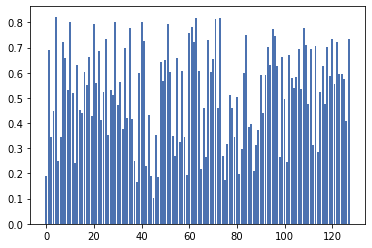

In [48]:
plt.bar(list(range(128)), pvals)

In [30]:
len(ref), len(target)

(72048, 33483)

In [35]:
calc_p_real(ref["error"].values, target["error"].values)

0.0

In [40]:
from scipy.stats import ks_2samp
ks_2samp(ref["error"].values, target["error"].values)

KstestResult(statistic=0.7812000458713196, pvalue=0.0)

In [36]:
ref["error"].values[:10]

array([0.01757107, 0.01544717, 0.03388681, 0.02718422, 0.0182364 ,
       0.02239492, 0.01763722, 0.02342774, 0.02066833, 0.01490599])

In [37]:
target["error"].values[:10]

array([0.03697437, 0.07537937, 0.0655725 , 0.0382699 , 0.09068341,
       0.04687092, 0.06717499, 0.04179861, 0.06267914, 0.10051547])

In [79]:
import numpy as np
from scipy import stats
from numpy.random import randn
from numpy.random import lognormal

data_norm1 = randn(100000)
data_lognormal = lognormal(3, 1, 100000)
data_norm2 = randn(100000)

print("KS Test")
print(" norm1 vs lognormal:", ks_2samp(data_norm1, data_lognormal))
print(" norm1 vs norm2:", ks_2samp(data_norm1, data_norm2))
print(" norm1 vs norm1:", ks_2samp(data_norm1, data_norm1))
print(" norm1 vs norm2+lognormal:", ks_2samp(data_norm1, np.hstack([data_norm2, data_lognormal])))



print("T Test")
print(" norm1 vs lognormal:", stats.ttest_ind(data_norm1, data_lognormal, equal_var=False))
print(" norm1 vs norm2:", stats.ttest_ind(data_norm1, data_norm2, equal_var=False))
print(" norm1 vs norm1:", stats.ttest_ind(data_norm1, data_norm1, equal_var=False))

print(" norm1 vs norm2+lognormal:", stats.ttest_ind(data_norm1, np.hstack([data_norm2, data_lognormal]), equal_var=False))

KS Test
 norm1 vs lognormal: KstestResult(statistic=0.9754700000000001, pvalue=0.0)
 norm1 vs norm2: KstestResult(statistic=0.004660000000000025, pvalue=0.22695829580536986)
 norm1 vs norm1: KstestResult(statistic=0.0, pvalue=1.0)
 norm1 vs norm2+lognormal: KstestResult(statistic=0.48797, pvalue=0.0)
T Test
 norm1 vs lognormal: Ttest_indResult(statistic=-236.62667596670116, pvalue=0.0)
 norm1 vs norm2: Ttest_indResult(statistic=-1.3965286437253737, pvalue=0.16255691100702027)
 norm1 vs norm1: Ttest_indResult(statistic=0.0, pvalue=1.0)
 norm1 vs norm2+lognormal: Ttest_indResult(statistic=-209.03422184979513, pvalue=0.0)


norm1 vs lognormal: Ttest_indResult(statistic=-242.74750481334817, pvalue=0.0)
norm1 vs norm2: Ttest_indResult(statistic=-0.9231148953999398, pvalue=0.35594844666215886)
norm1 vs norm1: Ttest_indResult(statistic=0.0, pvalue=1.0)
norm1 vs norm2+lognormal: Ttest_indResult(statistic=-213.19888824579922, pvalue=0.0)


In [ ]:
from scipy.stats import ks_2samp
ks_2samp(ref["error"].values, target["error"].values)

KstestResult(statistic=0.7812000458713196, pvalue=0.0)